# Pulling our FYP Repository

In [ ]:
!rm -rf model-experiments ; git clone https://github.com/c137519edbb3/model-experiments

Cloning into 'model-experiments'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 201 (delta 11), reused 17 (delta 6), pack-reused 177 (from 1)
Receiving objects: 100% (201/201), 44.73 MiB | 46.73 MiB/s, done.
Resolving deltas: 100% (28/28), done.


# Installing modules

In [ ]:
! cd /content/model-experiments/models ; pip install -r requirements.txt

# Few Shot Fine-tuning on CLIP Model using Linear Probing++

**Hyper parameters** \\
shots: 16 \\
tasks: 4 \\
learning rate: 0.001 \\
epochs: 16 \\
batch_size: 256 \\
Linear probe steps: 8 \\
backbone: ViT-B/32 \\
Precision: fp16 \\
init_beta: 1 \\
init_alpha: 1 \\
init_alpha_scale: 10 \\
augment_epoch: 1 \\

**Tasks** \\
'student being punished': 0 \\
'students fighting': 1 \\
'teacher checking notebook': 2 \\
'teacher using mobile phones': 3

In [ ]:
! cd /content/model-experiments/models ; python main.py --base_config configs/base.yaml --dataset_config configs/eyecon.yaml --opt root_path $DATA . output_dir ./outputs method LinearProbe_P2 shots 16 tasks 4


Running configs.
CLASS_TOKEN_POSITION: end
CSC: False
CTX_INIT: 
NCTX: 16
PREC: fp16
WARMUP_CONS_LR: 1e-05
WARMUP_EPOCH: 1
alpha_ca: 0.5
augment_epoch: 1
backbone: ViT-B/32
batch_size: 256
cache_dir: ./caches/eyecon
dataset: eyecon
finetune: True
grid_search: True
init_alpha: 1
init_alpha_scale: 10
init_beta: 1
load_cache: False
load_pre_feat: False
lr: 0.001
method: LinearProbe_P2
num_step: 8
output_dir: ./outputs
root_path: .
search_alpha_ca: False
search_hp: True
search_scale: [50, 50]
search_step: [200, 200]
shots: 16
tasks: 4
train_epoch: 16 

Preparing dataset.
['student being punished', 'students fighting', 'teacher checking notebook', 'teacher using mobile phones']
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation mi

# Performing Inference from repo argument parsing

In [ ]:
! cd /content/model-experiments/models ; python inference.py --frame /content/00003.png

/content/model-experiments/models/inference.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.lp_weights = torch.load(model_path, map_location=self.device)
/content/

# Defining CLIP architecture to perform inference within notebook

In [ ]:
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def default_bpe():
    return "/content/model-experiments/models/clip/bpe_simple_vocab_16e6.txt.gz"


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = default_bpe()):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


In [ ]:
from collections import OrderedDict
from typing import Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()


In [ ]:
import hashlib
import os
import urllib
import warnings
from typing import Any, Union, List

import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC


if torch.__version__.split(".") < ["1", "7", "1"]:
    warnings.warn("PyTorch version 1.7.1 or higher is recommended")


__all__ = ["available_models", "load", "tokenize"]
_tokenizer = SimpleTokenizer()

_MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}


def _download(url: str, root: str):
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    download_target = os.path.join(root, filename)

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        raise RuntimeError(f"Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])


def available_models() -> List[str]:
    """Returns the names of available CLIP models"""
    return list(_MODELS.keys())


def load(name: str, device: Union[str, torch.device] = "cuda" if torch.cuda.is_available() else "cpu", jit: bool = False, download_root: str = None):
    """Load a CLIP model

    Parameters
    ----------
    name : str
        A model name listed by `clip.available_models()`, or the path to a model checkpoint containing the state_dict

    device : Union[str, torch.device]
        The device to put the loaded model

    jit : bool
        Whether to load the optimized JIT model or more hackable non-JIT model (default).

    download_root: str
        path to download the model files; by default, it uses "~/.cache/clip"

    Returns
    -------
    model : torch.nn.Module
        The CLIP model

    preprocess : Callable[[PIL.Image], torch.Tensor]
        A torchvision transform that converts a PIL image into a tensor that the returned model can take as its input
    """
    if name in _MODELS:
        model_path = _download(_MODELS[name], download_root or os.path.expanduser("~/.cache/clip"))
    elif os.path.isfile(name):
        model_path = name
    else:
        raise RuntimeError(f"Model {name} not found; available models = {available_models()}")

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location=device if jit else "cpu").eval()
        state_dict = None
    except RuntimeError:
        # loading saved state dict
        if jit:
            warnings.warn(f"File {model_path} is not a JIT archive. Loading as a state dict instead")
            jit = False
        state_dict = torch.load(model_path, map_location="cpu")

    if not jit:
        model = build_model(state_dict or model.state_dict()).to(device)
        if str(device) == "cpu":
            model.float()
        return model, _transform(model.visual.input_resolution)

    # patch the device names
    device_holder = torch.jit.trace(lambda: torch.ones([]).to(torch.device(device)), example_inputs=[])
    device_node = [n for n in device_holder.graph.findAllNodes("prim::Constant") if "Device" in repr(n)][-1]

    def patch_device(module):
        try:
            graphs = [module.graph] if hasattr(module, "graph") else []
        except RuntimeError:
            graphs = []

        if hasattr(module, "forward1"):
            graphs.append(module.forward1.graph)

        for graph in graphs:
            for node in graph.findAllNodes("prim::Constant"):
                if "value" in node.attributeNames() and str(node["value"]).startswith("cuda"):
                    node.copyAttributes(device_node)

    model.apply(patch_device)
    patch_device(model.encode_image)
    patch_device(model.encode_text)

    # patch dtype to float32 on CPU
    if str(device) == "cpu":
        float_holder = torch.jit.trace(lambda: torch.ones([]).float(), example_inputs=[])
        float_input = list(float_holder.graph.findNode("aten::to").inputs())[1]
        float_node = float_input.node()

        def patch_float(module):
            try:
                graphs = [module.graph] if hasattr(module, "graph") else []
            except RuntimeError:
                graphs = []

            if hasattr(module, "forward1"):
                graphs.append(module.forward1.graph)

            for graph in graphs:
                for node in graph.findAllNodes("aten::to"):
                    inputs = list(node.inputs())
                    for i in [1, 2]:  # dtype can be the second or third argument to aten::to()
                        if inputs[i].node()["value"] == 5:
                            inputs[i].node().copyAttributes(float_node)

        model.apply(patch_float)
        patch_float(model.encode_image)
        patch_float(model.encode_text)

        model.float()

    return model, _transform(model.input_resolution.item())


def tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> torch.LongTensor:
    """
    Returns the tokenized representation of given input string(s)

    Parameters
    ----------
    texts : Union[str, List[str]]
        An input string or a list of input strings to tokenize

    context_length : int
        The context length to use; all CLIP models use 77 as the context length

    truncate: bool
        Whether to truncate the text in case its encoding is longer than the context length

    Returns
    -------
    A two-dimensional tensor containing the resulting tokens, shape = [number of input strings, context_length]
    """
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

    for i, tokens in enumerate(all_tokens):
        if len(tokens) > context_length:
            if truncate:
                tokens = tokens[:context_length]
                tokens[-1] = eot_token
            else:
                raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
        result[i, :len(tokens)] = torch.tensor(tokens)

    return result


<ipython-input-77-c9ed0622dc99>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.lp_weights = torch.load(model_path, map_location=self.device)
<ipython-input-77-c9ed06

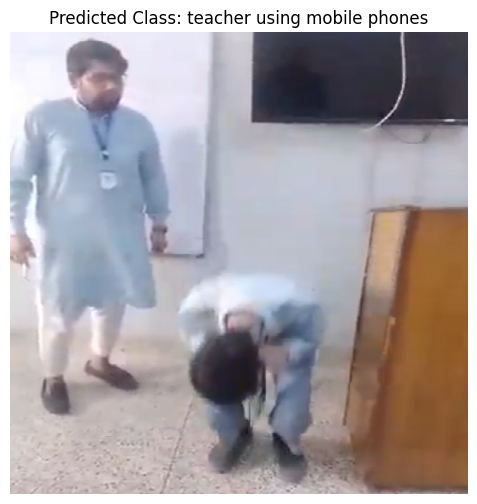

Image 00001:
Predicted Class: 3
Class Probabilities: tensor([[0.2951, 0.1965, 0.2066, 0.3018]])
------------------------------


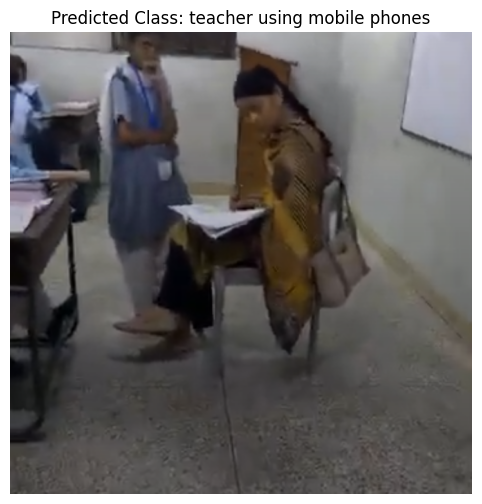

Image 00002:
Predicted Class: 3
Class Probabilities: tensor([[0.2803, 0.1864, 0.2042, 0.3291]])
------------------------------


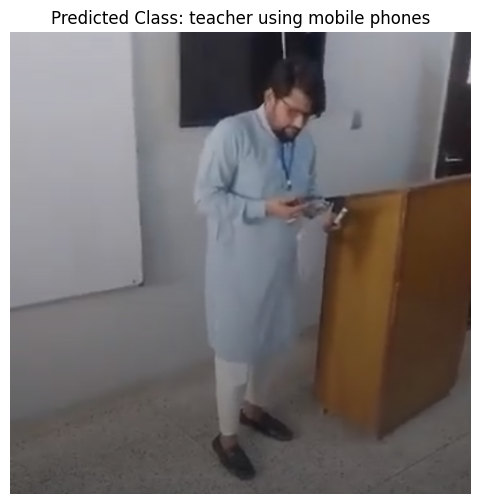

Image 00003:
Predicted Class: 3
Class Probabilities: tensor([[0.2911, 0.1755, 0.2221, 0.3112]])
------------------------------


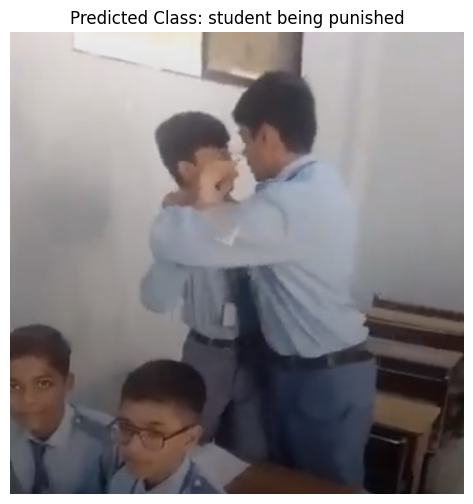

Image 00004:
Predicted Class: 0
Class Probabilities: tensor([[0.3092, 0.2154, 0.2089, 0.2665]])
------------------------------


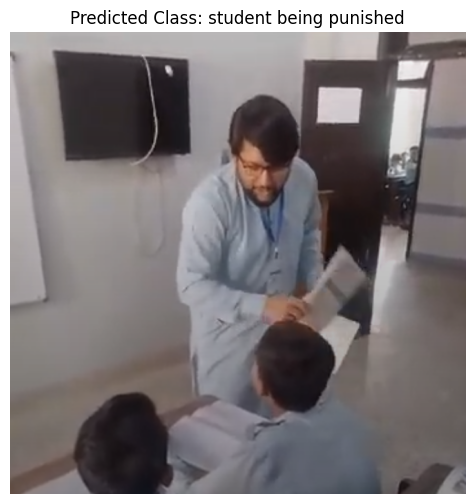

Image 00005:
Predicted Class: 0
Class Probabilities: tensor([[0.3025, 0.1951, 0.2306, 0.2717]])
------------------------------


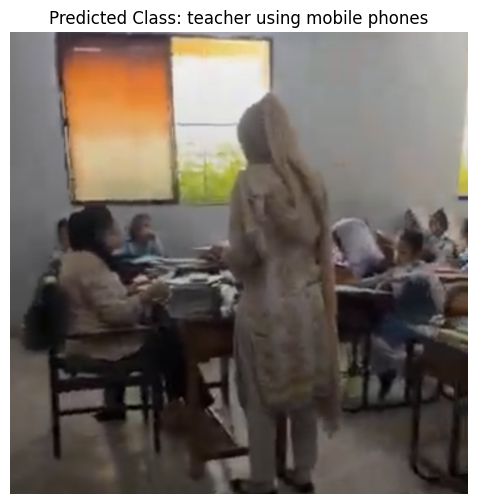

Image 00006:
Predicted Class: 3
Class Probabilities: tensor([[0.2974, 0.1521, 0.2239, 0.3266]])
------------------------------


In [ ]:
import argparse
import torch
from PIL import Image
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from pathlib import Path

class CLIPLPInference:
    def __init__(self, model_path, num_classes, device=None):
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes

        # Load the base CLIP model and preprocessing
        self.base_model, self.preprocess =  load('ViT-B/32', device=self.device)

        # Add classification head
        self.classifier = torch.nn.Linear(512, num_classes).to(self.device)

        # Load LP++ weights
        self.lp_weights = torch.load(model_path, map_location=self.device)

        # Apply weights to the model and classifier
        if isinstance(self.lp_weights, dict):
            if 'model_state_dict' in self.lp_weights:
                # Separate CLIP and classifier weights
                clip_weights = {k: v for k, v in self.lp_weights['model_state_dict'].items()
                              if not k.startswith('classifier')}
                classifier_weights = {k.replace('classifier.', ''): v
                                   for k, v in self.lp_weights['model_state_dict'].items()
                                   if k.startswith('classifier')}

                self.base_model.load_state_dict(clip_weights, strict=False)
                self.classifier.load_state_dict(classifier_weights)

        self.base_model.eval()
        self.classifier.eval()

        # Define standard CLIP preprocessing
        self.transform = Compose([
            Resize(224, interpolation=Image.BICUBIC),
            CenterCrop(224),
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073),
                     (0.26862954, 0.26130258, 0.27577711))
        ])

    @torch.no_grad()
    def process_image(self, image_path):
        """
        Process a single image and return the features and classification results.
        """
        # Load and preprocess image
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path.convert('RGB')

        image = self.transform(image).unsqueeze(0).to(self.device)

        # Get image features
        with torch.cuda.amp.autocast(enabled=False):
            features = self.base_model.encode_image(image)
            features = features.float()

        # Get classification results
        logits = self.classifier(features)
        probs = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1)

        return {
            # 'features': features.cpu(),
            # 'logits': logits.cpu(),
            'probabilities': probs.cpu(),
            'predicted_class': predicted_class.cpu().item()
        }

    @torch.no_grad()
    def batch_process(self, image_paths, batch_size=32):
        """
        Process multiple images in batches
        """
        all_results = []

        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = [Image.open(path).convert('RGB') for path in batch_paths]
            batch_tensors = torch.stack([self.transform(img) for img in batch_images]).to(self.device)

            features = self.base_model.encode_image(batch_tensors)
            logits = self.classifier(features)
            probs = torch.softmax(logits, dim=-1)
            predicted_classes = torch.argmax(probs, dim=-1)

            batch_results = [{
                'features': feat.cpu(),
                'logits': log.cpu(),
                'probabilities': prob.cpu(),
                'predicted_class': pred.cpu().item()
            } for feat, log, prob, pred in zip(features, logits, probs, predicted_classes)]

            all_results.extend(batch_results)

        return all_results

def main():
    # Example usage
    model_path = '/content/best_lp_model_16shots.pt'
    num_classes = 4  # Set this to your number of classes
    inferencer = CLIPLPInference(model_path, num_classes)

    class_labels = {
        0: 'student being punished',
        1: 'students fighting',
        2: 'teacher checking notebook',
        3: 'teacher using mobile phones'
    }

    # Iterate over images from 0001.png to 0006.png
    for i in range(1, 7):
        image_path = f'/content/{i:05d}.png'
        result = inferencer.process_image(image_path)

        # Display the image
        image = Image.open(image_path).convert('RGB')
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"Predicted Class: {class_labels[result['predicted_class']]}")
        plt.axis('off')
        plt.show()

        # Print class probabilities
        print(f"Image {i:05d}:")
        print(f"Predicted Class: {result['predicted_class']}")
        print(f"Class Probabilities: {result['probabilities']}")
        print('-' * 30)

if __name__ == '__main__':
    main()